# Polymarket Election Markets — Time Series Analysis

**Goal:** Evaluate forecasting models on Polymarket election market price series and determine which model best predicts price evolution.

**Models:** Naive · Moving Average · ARIMA · Prophet · XGBoost · LSTM · Transformer

**Sections:**
1. Setup & Config
2. Data Loading
3. EDA
4. Stationarity & Autocorrelation
5. Feature Engineering
6. Grid Search (MA window + ARIMA order)
7. Model Definitions
8. Batch Evaluation
9. Results & Visualisation
10. Per-Market Deep Dive
11. Save Outputs

---
## 1. Setup & Config

In [12]:
from pathlib import Path
import json, math, warnings
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 5)

# ── Paths ─────────────────────────────────────────────────────────────────────
DATA_DIR      = Path('data/filtered')
MARKETS_JSONL = DATA_DIR / 'markets_filtered.jsonl'
PRICES_JSONL  = DATA_DIR / 'filtered_prices_by_tag.jsonl'
OUT_DIR       = DATA_DIR / 'analysis'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ── Hyperparameters ───────────────────────────────────────────────────────────
TRAIN_FRAC           = 0.8
MIN_POINTS           = 30       # min candles required per series
MAX_MARKETS_EVAL     = 100      # cap for classical models (all markets)
DEEP_MODEL_MAX       = 20       # cap for LSTM / Transformer (slow)
LOOKBACK             = 10       # sequence length for deep models
EPOCHS               = 30
BATCH_SIZE           = 32
SEED                 = 1337

# MA windows + ARIMA orders to grid-search
MA_WINDOWS           = [3, 5, 7, 10, 14]
ARIMA_ORDERS         = [(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

np.random.seed(SEED)
print('Setup complete')

Setup complete


---
## 2. Data Loading

In [13]:
def read_jsonl(path: Path) -> list[dict]:
    rows = []
    with path.open('r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

markets_raw  = read_jsonl(MARKETS_JSONL)
prices_raw   = read_jsonl(PRICES_JSONL)
markets_df   = pd.DataFrame(markets_raw)

print(f'Markets : {len(markets_df):,}')
print(f'Price records : {len(prices_raw):,}')
print(f'\nMarket columns: {list(markets_df.columns[:15])}')

Markets : 2,051
Price records : 4,070

Market columns: ['id', 'question', 'conditionId', 'slug', 'resolutionSource', 'endDate', 'startDate', 'fee', 'image', 'icon', 'description', 'outcomes', 'outcomePrices', 'volume', 'active']


In [14]:
# Expand price history into a flat DataFrame
def expand_history(price_rows: list[dict]) -> pd.DataFrame:
    records = []
    for row in price_rows:
        mid = row.get('market_id')
        tid = row.get('token_id')
        for point in row.get('history', []):
            if isinstance(point, dict):
                t, p = point.get('t'), point.get('p')
            elif isinstance(point, (list, tuple)) and len(point) >= 2:
                t, p = point[0], point[1]
            else:
                continue
            if t is None or p is None:
                continue
            records.append({
                'market_id': mid,
                'token_id' : tid,
                'timestamp': pd.to_datetime(t, unit='s', utc=True, errors='coerce'),
                'price'    : float(p),
            })
    df = pd.DataFrame(records)
    if df.empty:
        return pd.DataFrame(columns=['market_id','token_id','timestamp','price'])
    return df.dropna(subset=['timestamp']).sort_values(['market_id','timestamp'])

prices_df = expand_history(prices_raw)
print(f'Total price points: {len(prices_df):,}')
prices_df.head()

Total price points: 758,683


,market_id,token_id,timestamp,price
604744,1006897,4231208189438600128067527902251621102236391732...,2025-12-24 00:00:07+00:00,0.5000
604690,1006897,3458253652854995527086394443197271802643918247...,2025-12-24 00:00:10+00:00,0.5000
604745,1006897,4231208189438600128067527902251621102236391732...,2025-12-24 12:00:06+00:00,0.9920
604691,1006897,3458253652854995527086394443197271802643918247...,2025-12-24 12:00:09+00:00,0.0080
604746,1006897,4231208189438600128067527902251621102236391732...,2025-12-25 00:00:17+00:00,0.9915


In [15]:
# Build per-market daily price series (YES token only — price = P(YES))
# For binary markets, token index 0 is conventionally YES
def build_series(df: pd.DataFrame) -> dict[str, pd.Series]:
    series = {}
    # Use first token per market as the YES price
    first_token = df.groupby('market_id')['token_id'].first().to_dict()
    for mid, g in df.groupby('market_id'):
        tid = first_token.get(mid)
        g = g[g['token_id'] == tid].sort_values('timestamp')
        if g['timestamp'].nunique() < 2:
            continue
        # Skip series stuck at 0.5 with no movement (uninitialised markets)
        if g['price'].nunique() == 1 and round(float(g['price'].iloc[0]), 2) == 0.5:
            continue
        # Resample to 12h, forward-fill small gaps (max 2 periods)
        s = (g.set_index('timestamp')['price']
               .resample('12h').last()
               .ffill(limit=2)
               .dropna())
        if len(s) >= MIN_POINTS:
            series[mid] = s
    return series

series_by_market = build_series(prices_df)
print(f'Usable series: {len(series_by_market):,}')

Usable series: 1,800


---
## 3. EDA

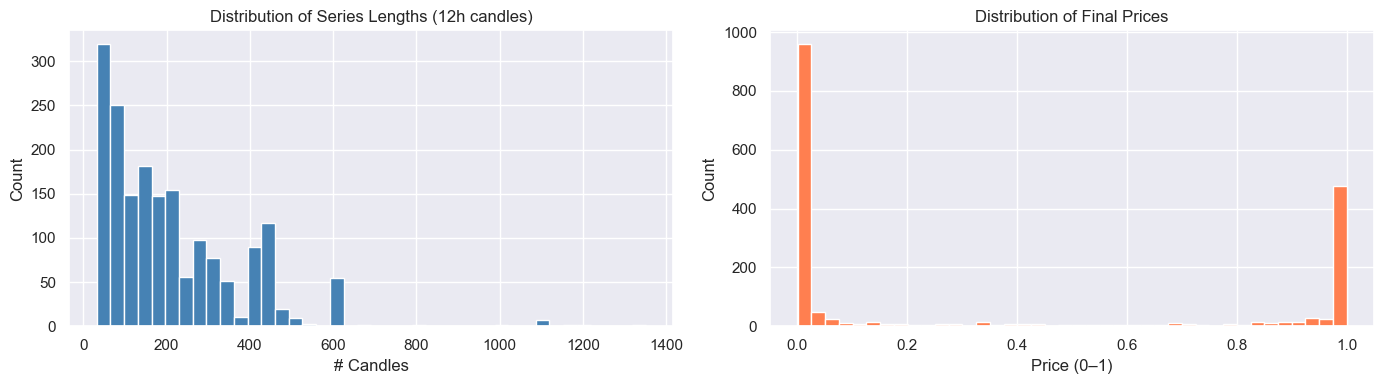

In [16]:
# Series length distribution
lengths = [len(s) for s in series_by_market.values()]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(lengths, bins=40, color='steelblue', edgecolor='white')
axes[0].set(title='Distribution of Series Lengths (12h candles)', xlabel='# Candles', ylabel='Count')

# Price range distribution (final price — proxy for resolution)
final_prices = [float(s.iloc[-1]) for s in series_by_market.values()]
axes[1].hist(final_prices, bins=40, color='coral', edgecolor='white')
axes[1].set(title='Distribution of Final Prices', xlabel='Price (0–1)', ylabel='Count')
plt.tight_layout()
plt.savefig(OUT_DIR / 'eda_distributions.png', dpi=150)
plt.show()

In [17]:
# Calibration check — core test of Polymarket CEO's claim
# Join final price to resolution value from markets_df
def get_resolution(m: dict) -> float | None:
    rv = m.get('resolutionValue') or m.get('resolution')
    if rv is None:
        return None
    try:
        v = float(rv)
        return v if 0 <= v <= 1 else (1.0 if str(rv).lower() in ('yes','1','true','win') else 0.0)
    except (TypeError, ValueError):
        return (1.0 if str(rv).lower() in ('yes','1','true','win') else 0.0)

resolved_map = {
    str(m.get('id') or m.get('conditionId','')): get_resolution(m)
    for m in markets_raw
    if m.get('resolved') or m.get('isResolved')
}

calib_rows = []
for mid, s in series_by_market.items():
    outcome = resolved_map.get(str(mid))
    if outcome is None:
        continue
    # Sample price at 25%, 50%, 75% through the market's life
    for frac, label in [(0.25,'t25'),(0.50,'t50'),(0.75,'t75')]:
        idx = int(len(s) * frac)
        calib_rows.append({'market_id': mid, 'timepoint': label,
                            'price': float(s.iloc[idx]), 'outcome': outcome})

calib_df = pd.DataFrame(calib_rows)
print(f'Calibration rows: {len(calib_df):,}')

if not calib_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for ax, tp in zip(axes, ['t25','t50','t75']):
        sub = calib_df[calib_df['timepoint'] == tp].copy()
        sub['bin'] = pd.cut(sub['price'], bins=np.linspace(0,1,11), labels=False)
        cal = sub.groupby('bin').agg(mean_price=('price','mean'),
                                      mean_outcome=('outcome','mean'),
                                      count=('outcome','count')).dropna()
        ax.scatter(cal['mean_price'], cal['mean_outcome'], s=cal['count']*3,
                   alpha=0.7, color='steelblue')
        ax.plot([0,1],[0,1],'r--', linewidth=1, label='Perfect calibration')
        ax.set(title=f'Calibration @ {tp}', xlabel='Market Price', ylabel='Actual Outcome Rate')
        ax.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'calibration.png', dpi=150)
    plt.show()
else:
    print('No resolved markets found — calibration plot skipped')

Calibration rows: 0
No resolved markets found — calibration plot skipped


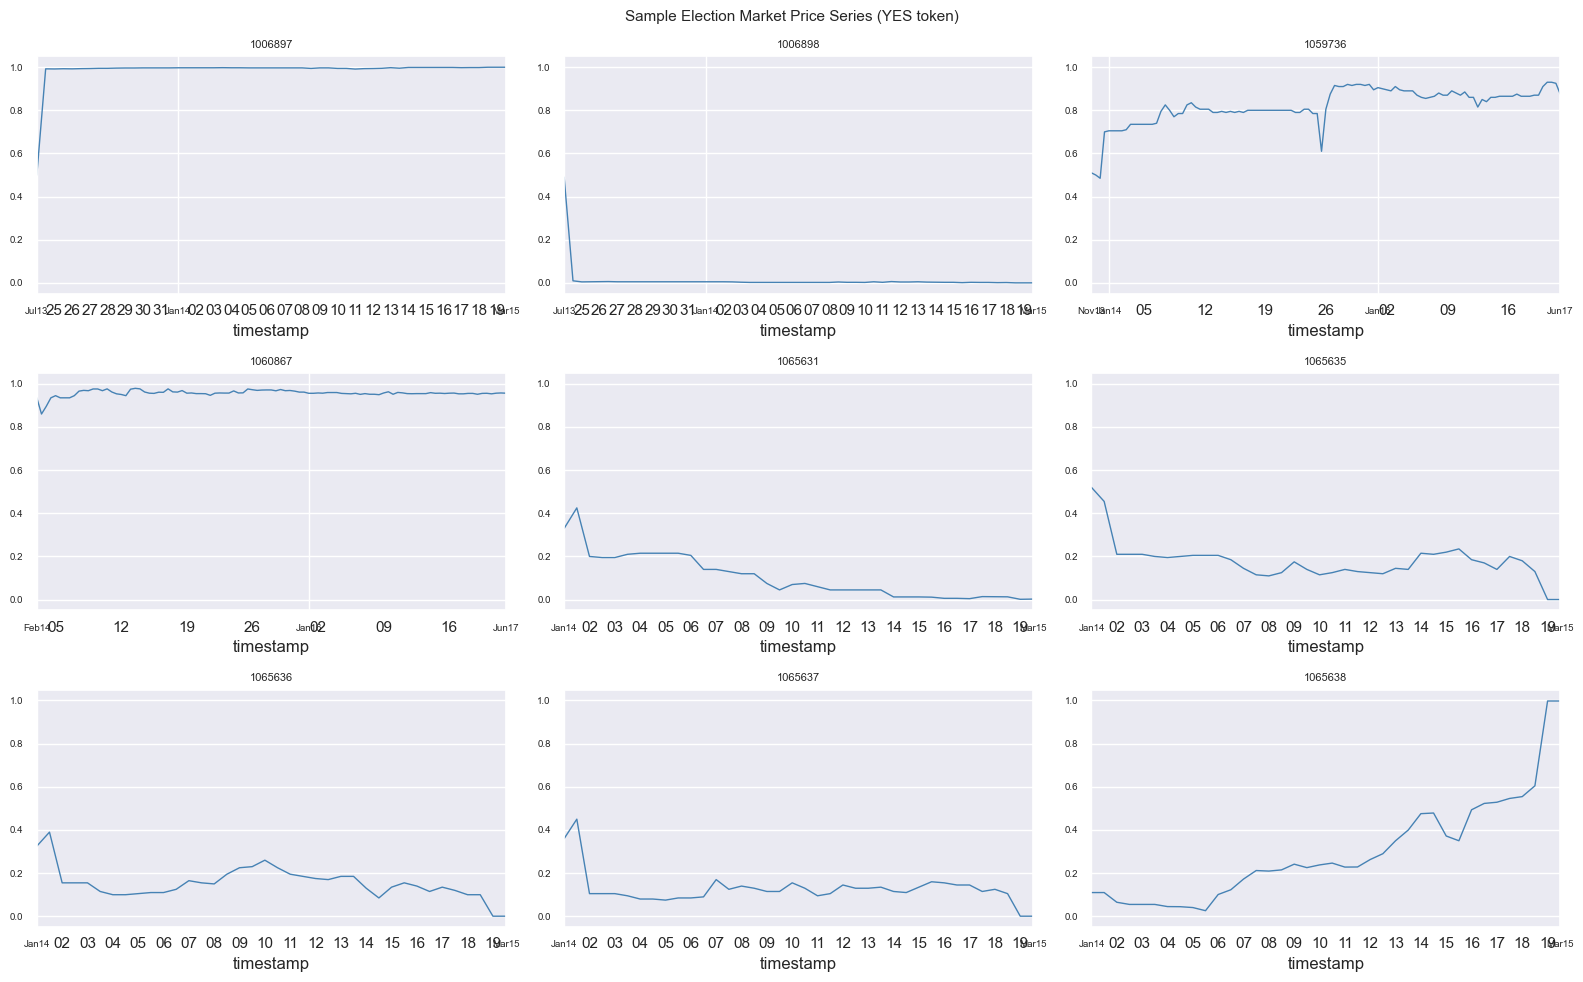

In [18]:
# Sample price series plots
sample = list(series_by_market.items())[:9]
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for ax, (mid, s) in zip(axes.flat, sample):
    s.plot(ax=ax, color='steelblue', linewidth=1)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(str(mid)[:30], fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
    ax.tick_params(labelsize=7)
for ax in axes.flat[len(sample):]:
    ax.set_visible(False)
plt.suptitle('Sample Election Market Price Series (YES token)', fontsize=11)
plt.tight_layout()
plt.savefig(OUT_DIR / 'sample_series.png', dpi=150)
plt.show()

---
## 4. Stationarity & Autocorrelation

Stationary series (p<0.05): 39.9%
Non-stationary (needs differencing): 60.1%


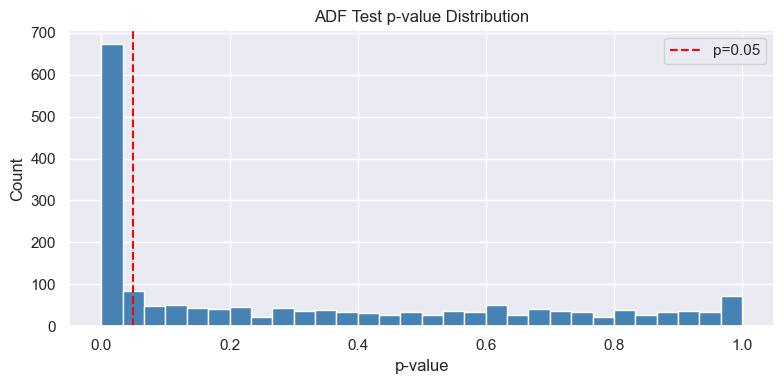

In [19]:
# ADF test across all series
adf_results = []
for mid, s in series_by_market.items():
    try:
        stat, pval, *_ = adfuller(s.values, autolag='AIC')
        adf_results.append({'market_id': mid, 'adf_stat': stat, 'p_value': pval,
                             'stationary': pval < 0.05})
    except Exception:
        continue

adf_df = pd.DataFrame(adf_results)
pct_stationary = adf_df['stationary'].mean() * 100
print(f'Stationary series (p<0.05): {pct_stationary:.1f}%')
print(f'Non-stationary (needs differencing): {100-pct_stationary:.1f}%')

fig, ax = plt.subplots(figsize=(8,4))
adf_df['p_value'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
ax.axvline(0.05, color='red', linestyle='--', label='p=0.05')
ax.set(title='ADF Test p-value Distribution', xlabel='p-value', ylabel='Count')
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'adf_pvalues.png', dpi=150)
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 30 must be < 27.

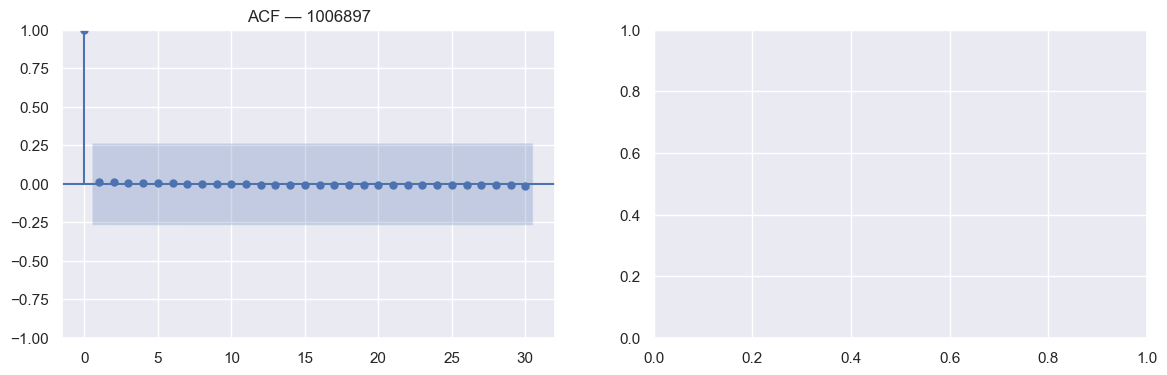

In [20]:
# ACF / PACF on a representative series
# Use the longest series so we have the most lags available
sample_mid = max(series_by_market, key=lambda k: len(series_by_market[k]))
sample_s   = series_by_market[sample_mid]

# PACF hard requirement: nlags < len(series) / 2
max_lags = min(30, len(sample_s) // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(sample_s,  lags=max_lags, ax=axes[0], title=f'ACF — {str(sample_mid)[:25]}')
plot_pacf(sample_s, lags=max_lags, ax=axes[1], title=f'PACF — {str(sample_mid)[:25]}')
plt.tight_layout()
plt.savefig(OUT_DIR / 'acf_pacf.png', dpi=150)
plt.show()

---
## 5. Feature Engineering

In [ ]:
def build_features(s: pd.Series, lookback: int = 10) -> pd.DataFrame:
    """Build a supervised feature DataFrame from a price series."""
    df = pd.DataFrame({'price': s})

    # Lags
    for lag in range(1, lookback + 1):
        df[f'lag_{lag}'] = df['price'].shift(lag)

    # Rolling statistics
    for w in [3, 5, 10]:
        df[f'roll_mean_{w}'] = df['price'].shift(1).rolling(w).mean()
        df[f'roll_std_{w}']  = df['price'].shift(1).rolling(w).std()

    # Momentum & returns
    df['return_1']   = df['price'].pct_change(1)
    df['return_3']   = df['price'].pct_change(3)
    df['momentum_5'] = df['price'] - df['price'].shift(5)

    # Distance from extremes (how close to resolution)
    df['dist_from_0'] = df['price']
    df['dist_from_1'] = 1 - df['price']
    df['dist_from_half'] = (df['price'] - 0.5).abs()

    # Time features
    df['t_index']    = np.arange(len(df)) / len(df)  # normalised position in life
    df['hour']       = df.index.hour
    df['dayofweek']  = df.index.dayofweek

    # Target: next price
    df['target'] = df['price'].shift(-1)

    return df.dropna()

# Verify on one series
sample_feat = build_features(series_by_market[sample_mid])
print(f'Feature columns ({len(sample_feat.columns)}): {list(sample_feat.columns)}')
sample_feat.head(3)

---
## 6. Grid Search (MA window + ARIMA order)

In [ ]:
def train_test_split_series(s: pd.Series, train_frac: float):
    k = int(len(s) * train_frac)
    return s.iloc[:k], s.iloc[k:]

def rmse(y_true, y_pred): return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)))
def mae(y_true, y_pred):  return float(np.mean(np.abs(np.array(y_true) - np.array(y_pred))))
def mape(y_true, y_pred):
    yt, yp = np.array(y_true), np.array(y_pred)
    denom = np.where(yt == 0, np.nan, yt)
    return float(np.nanmean(np.abs((yt - yp) / denom)))
def directional_acc(y_true, y_pred):
    if len(y_true) < 2: return np.nan
    return float(np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))))

def eval_metrics(y_true, y_pred) -> dict:
    return {'rmse': rmse(y_true,y_pred), 'mae': mae(y_true,y_pred),
            'mape': mape(y_true,y_pred), 'directional_acc': directional_acc(y_true,y_pred)}

def forecast_naive(train, steps): return np.repeat(float(train.iloc[-1]), steps)
def forecast_ma(train, steps, window=5): return np.repeat(float(train.tail(window).mean()), steps)

In [ ]:
GRID_MARKETS = 10
grid_series  = list(series_by_market.items())[:GRID_MARKETS]
grid_rows    = []

for mid, s in grid_series:
    train, test = train_test_split_series(s, TRAIN_FRAC)
    steps = len(test)
    if steps < 2:
        continue

    for w in MA_WINDOWS:
        pred    = forecast_ma(train, steps, window=w)
        metrics = eval_metrics(test.values, pred)
        grid_rows.append({'model':'ma', 'param': w, **metrics})

    for order in ARIMA_ORDERS:
        try:
            pred = ARIMA(train, order=order).fit().forecast(steps=steps).values
            metrics = eval_metrics(test.values, pred)
            grid_rows.append({'model':'arima', 'param': str(order), **metrics})
        except Exception:
            continue

grid_df = pd.DataFrame(grid_rows)
if not grid_df.empty:
    grid_summary = (grid_df.groupby(['model','param'])
                           [['rmse','mae','directional_acc']].mean()
                           .sort_values('rmse'))
    print('Top configurations by RMSE:')
    print(grid_summary.head(10))
    BEST_MA_WINDOW   = int(grid_df[grid_df['model']=='ma'].groupby('param')['rmse'].mean().idxmin())
    BEST_ARIMA_ORDER = eval(grid_df[grid_df['model']=='arima'].groupby('param')['rmse'].mean().idxmin())
else:
    BEST_MA_WINDOW, BEST_ARIMA_ORDER = 5, (1,1,1)
    print('Grid search empty — using defaults')

print(f'\nBest MA window   : {BEST_MA_WINDOW}')
print(f'Best ARIMA order : {BEST_ARIMA_ORDER}')

---
## 7. Model Definitions

In [ ]:
def forecast_arima(train, steps, order=None):
    order = order or BEST_ARIMA_ORDER
    try:
        return ARIMA(train, order=order).fit().forecast(steps=steps).values
    except Exception:
        return None

def forecast_prophet(train, steps):
    try:
        try:
            from prophet import Prophet
        except ImportError:
            from fbprophet import Prophet
        df = pd.DataFrame({'ds': train.index.tz_convert(None), 'y': train.values})
        m  = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
        m.fit(df)
        future = m.make_future_dataframe(periods=steps, freq='12h')
        fc     = m.predict(future)
        preds  = fc['yhat'].tail(steps).values
        return np.clip(preds, 0, 1)
    except Exception:
        return None

def forecast_xgboost(train, steps, lookback=10):
    try:
        import xgboost as xgb
        feat_df = build_features(train, lookback=lookback)
        if len(feat_df) < lookback + 5:
            return None
        feature_cols = [c for c in feat_df.columns if c != 'target']
        X, y = feat_df[feature_cols].values, feat_df['target'].values
        model = xgb.XGBRegressor(n_estimators=100, max_depth=3,
                                  learning_rate=0.05, random_state=SEED,
                                  verbosity=0)
        model.fit(X, y)
        # Autoregressive multi-step forecast
        history = train.copy()
        preds   = []
        for _ in range(steps):
            feat = build_features(history, lookback=lookback)
            if feat.empty:
                break
            x_pred = feat[feature_cols].iloc[-1:].values
            yhat   = float(model.predict(x_pred)[0])
            yhat   = np.clip(yhat, 0, 1)
            preds.append(yhat)
            new_idx = history.index[-1] + pd.tseries.frequencies.to_offset('12h')
            history = pd.concat([history, pd.Series([yhat], index=[new_idx])])
        return np.array(preds) if preds else None
    except Exception:
        return None

def make_supervised(series, lookback):
    values = series.values
    X, y   = [], []
    for i in range(len(values) - lookback):
        X.append(values[i:i+lookback])
        y.append(values[i+lookback])
    return np.array(X), np.array(y)

def forecast_lstm(train, steps, lookback=LOOKBACK):
    try:
        import torch
        import torch.nn as nn
        X, y = make_supervised(train, lookback)
        if len(X) < 10:
            return None
        Xt = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        yt = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

        class LSTMModel(nn.Module):
            def __init__(self, hidden=32):
                super().__init__()
                self.lstm = nn.LSTM(1, hidden, batch_first=True)
                self.fc   = nn.Linear(hidden, 1)
            def forward(self, x):
                out, _ = self.lstm(x)
                return self.fc(out[:, -1, :])

        model   = LSTMModel()
        opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        for _ in range(EPOCHS):
            idx = torch.randperm(len(Xt))
            for i in range(0, len(Xt), BATCH_SIZE):
                b = idx[i:i+BATCH_SIZE]
                opt.zero_grad()
                loss = loss_fn(model(Xt[b]), yt[b])
                loss.backward()
                opt.step()

        history = train.values.tolist()
        preds   = []
        model.eval()
        for _ in range(steps):
            x    = torch.tensor(history[-lookback:], dtype=torch.float32).view(1, lookback, 1)
            with torch.no_grad():
                yhat = float(model(x).item())
            preds.append(np.clip(yhat, 0, 1))
            history.append(yhat)
        return np.array(preds)
    except Exception:
        return None

def forecast_transformer(train, steps, lookback=LOOKBACK):
    try:
        import torch
        import torch.nn as nn
        X, y = make_supervised(train, lookback)
        if len(X) < 10:
            return None
        Xt = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        yt = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

        class TransformerModel(nn.Module):
            def __init__(self, d_model=32, nhead=4, num_layers=2):
                super().__init__()
                self.proj    = nn.Linear(1, d_model)
                enc_layer    = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                          batch_first=True, dim_feedforward=64)
                self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
                self.fc      = nn.Linear(d_model, 1)
            def forward(self, x):
                return self.fc(self.encoder(self.proj(x))[:, -1, :])

        model   = TransformerModel()
        opt     = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        for _ in range(EPOCHS):
            idx = torch.randperm(len(Xt))
            for i in range(0, len(Xt), BATCH_SIZE):
                b = idx[i:i+BATCH_SIZE]
                opt.zero_grad()
                loss = loss_fn(model(Xt[b]), yt[b])
                loss.backward()
                opt.step()

        history = train.values.tolist()
        preds   = []
        model.eval()
        for _ in range(steps):
            x = torch.tensor(history[-lookback:], dtype=torch.float32).view(1, lookback, 1)
            with torch.no_grad():
                yhat = float(model(x).item())
            preds.append(np.clip(yhat, 0, 1))
            history.append(yhat)
        return np.array(preds)
    except Exception:
        return None

print('All model functions defined')

---
## 8. Batch Evaluation

In [ ]:
# Sort by series length descending so the longest (richest) series go first
all_markets  = sorted(series_by_market.items(), key=lambda x: len(x[1]), reverse=True)
eval_markets = all_markets[:MAX_MARKETS_EVAL]
deep_ids     = {m[0] for m in eval_markets[:DEEP_MODEL_MAX]}

results = []
total   = len(eval_markets)

for i, (mid, s) in enumerate(eval_markets, 1):
    train, test = train_test_split_series(s, TRAIN_FRAC)
    steps = len(test)
    if steps < 2:
        continue

    preds = {}
    preds['naive']  = forecast_naive(train, steps)
    preds[f'ma_{BEST_MA_WINDOW}'] = forecast_ma(train, steps, window=BEST_MA_WINDOW)

    arima_p = forecast_arima(train, steps)
    if arima_p is not None: preds['arima'] = arima_p

    prophet_p = forecast_prophet(train, steps)
    if prophet_p is not None: preds['prophet'] = prophet_p

    xgb_p = forecast_xgboost(train, steps)
    if xgb_p is not None: preds['xgboost'] = xgb_p

    if mid in deep_ids:
        lstm_p = forecast_lstm(train, steps)
        if lstm_p is not None: preds['lstm'] = lstm_p

        trans_p = forecast_transformer(train, steps)
        if trans_p is not None: preds['transformer'] = trans_p

    for model_name, yhat in preds.items():
        metrics = eval_metrics(test.values, yhat)
        results.append({'market_id': mid, 'model': model_name,
                        'n_train': len(train), 'n_test': len(test), **metrics})

    if i % 10 == 0 or i == total:
        print(f'[{i}/{total}] done')

results_df = pd.DataFrame(results)
print(f'\nTotal result rows: {len(results_df):,}')
results_df.head()

---
## 9. Results & Visualisation

In [ ]:
# Mean metrics per model
summary = (results_df.groupby('model')[['rmse','mae','mape','directional_acc']]
                     .mean()
                     .sort_values('rmse'))
print('=== Mean Metrics by Model ===')
print(summary.to_string())

In [ ]:
# Average rank per model (lower rank = better)
ranked = results_df.copy()
ranked['rank_rmse'] = ranked.groupby('market_id')['rmse'].rank(method='average')
ranked['rank_mae']  = ranked.groupby('market_id')['mae'].rank(method='average')
ranked['rank_dir']  = ranked.groupby('market_id')['directional_acc'].rank(ascending=False, method='average')
rank_summary = ranked.groupby('model')[['rank_rmse','rank_mae','rank_dir']].mean().sort_values('rank_rmse')
print('=== Average Rank per Model (1 = best) ===')
print(rank_summary.to_string())

In [ ]:
# How often is each model the best on a given market?
best_model = results_df.loc[results_df.groupby('market_id')['rmse'].idxmin(), 'model']
win_rate   = best_model.value_counts(normalize=True).rename('win_rate')
print('=== % of Markets Where Each Model Wins (lowest RMSE) ===')
print((win_rate * 100).round(1).to_string())

In [ ]:
# ── Visualisations ────────────────────────────────────────────────────────────

# 1. Bar chart — mean RMSE by model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
summary['rmse'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set(title='Mean RMSE by Model', xlabel='RMSE')

summary['directional_acc'].sort_values(ascending=False).plot(
    kind='barh', ax=axes[1], color='coral', edgecolor='white')
axes[1].set(title='Mean Directional Accuracy by Model', xlabel='Accuracy')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=1, label='Random (0.5)')
axes[1].legend()
plt.tight_layout()
plt.savefig(OUT_DIR / 'model_comparison_bar.png', dpi=150)
plt.show()

In [ ]:
# 2. RMSE distribution per model (box plot)
fig, ax = plt.subplots(figsize=(12, 5))
order   = results_df.groupby('model')['rmse'].mean().sort_values().index.tolist()
results_df.boxplot(column='rmse', by='model', ax=ax,
                   order=order, showfliers=False)
ax.set(title='RMSE Distribution by Model', xlabel='Model', ylabel='RMSE')
plt.suptitle('')
plt.tight_layout()
plt.savefig(OUT_DIR / 'rmse_boxplot.png', dpi=150)
plt.show()

In [ ]:
# 3. Win-rate pie chart
fig, ax = plt.subplots(figsize=(7, 7))
win_rate.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90)
ax.set(title='% of Markets Won (lowest RMSE)', ylabel='')
plt.tight_layout()
plt.savefig(OUT_DIR / 'model_win_rate.png', dpi=150)
plt.show()

In [ ]:
# 4. RMSE vs series length — does more data help?
fig, ax = plt.subplots(figsize=(10, 5))
for model in results_df['model'].unique():
    sub = results_df[results_df['model'] == model]
    ax.scatter(sub['n_train'], sub['rmse'], alpha=0.3, label=model, s=15)
ax.set(title='RMSE vs Training Length', xlabel='Training Candles', ylabel='RMSE')
ax.legend(markerscale=2)
plt.tight_layout()
plt.savefig(OUT_DIR / 'rmse_vs_length.png', dpi=150)
plt.show()

---
## 10. Per-Market Deep Dive

In [ ]:
# Pick 3 markets: best RMSE overall, median, worst
best_rmse_per_market = results_df.groupby('market_id')['rmse'].min().sort_values()
n = len(best_rmse_per_market)
showcase_ids = [
    best_rmse_per_market.index[0],
    best_rmse_per_market.index[n // 2],
    best_rmse_per_market.index[-1],
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ['Best', 'Median', 'Worst']

for ax, mid, label in zip(axes, showcase_ids, labels):
    s = series_by_market[mid]
    train, test = train_test_split_series(s, TRAIN_FRAC)
    steps = len(test)

    ax.plot(train.index, train.values, color='steelblue', label='Train', linewidth=1)
    ax.plot(test.index,  test.values,  color='black',     label='Actual', linewidth=1.5)

    # Overlay all available model forecasts
    colors = ['coral','green','purple','orange','brown']
    model_funcs = [
        ('naive',   forecast_naive),
        (f'ma_{BEST_MA_WINDOW}', lambda tr, st: forecast_ma(tr, st, window=BEST_MA_WINDOW)),
        ('arima',   forecast_arima),
        ('xgboost', forecast_xgboost),
    ]
    for (mname, mfunc), col in zip(model_funcs, colors):
        try:
            pred = mfunc(train, steps)
            if pred is not None:
                ax.plot(test.index, pred, color=col, linestyle='--',
                        linewidth=1, label=mname, alpha=0.8)
        except Exception:
            continue

    ax.axvline(test.index[0], color='grey', linestyle=':', linewidth=1)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f'{label} — {str(mid)[:22]}', fontsize=9)
    ax.legend(fontsize=7)

plt.suptitle('Forecast Comparison: Best / Median / Worst Markets', fontsize=11)
plt.tight_layout()
plt.savefig(OUT_DIR / 'forecast_showcase.png', dpi=150)
plt.show()

In [ ]:
# Residual analysis for the best model on the best market
best_market_id    = best_rmse_per_market.index[0]
best_model_name   = results_df[results_df['market_id'] == best_market_id].sort_values('rmse').iloc[0]['model']
s_best            = series_by_market[best_market_id]
train_b, test_b   = train_test_split_series(s_best, TRAIN_FRAC)

model_dispatch = {
    'naive':   lambda tr, st: forecast_naive(tr, st),
    'arima':   lambda tr, st: forecast_arima(tr, st),
    'xgboost': lambda tr, st: forecast_xgboost(tr, st),
    'lstm':    lambda tr, st: forecast_lstm(tr, st),
    'transformer': lambda tr, st: forecast_transformer(tr, st),
    **{f'ma_{w}': (lambda w: lambda tr, st: forecast_ma(tr, st, window=w))(w) for w in MA_WINDOWS},
}
fn   = model_dispatch.get(best_model_name, lambda tr, st: forecast_naive(tr, st))
pred = fn(train_b, len(test_b))

if pred is not None:
    residuals = test_b.values - pred
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].plot(test_b.index, residuals)
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set(title='Residuals over Time', ylabel='Residual')

    axes[1].hist(residuals, bins=20, color='steelblue', edgecolor='white')
    axes[1].set(title='Residual Distribution')

    axes[2].scatter(pred, residuals, alpha=0.5, s=15)
    axes[2].axhline(0, color='red', linestyle='--')
    axes[2].set(title='Residuals vs Fitted', xlabel='Fitted', ylabel='Residual')

    plt.suptitle(f'Residual Analysis — {best_model_name} on market {str(best_market_id)[:25]}', fontsize=10)
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'residual_analysis.png', dpi=150)
    plt.show()

---
## 11. Save Outputs

In [ ]:
results_df.to_csv(OUT_DIR / 'model_results.csv', index=False)
summary.to_csv(OUT_DIR / 'model_summary.csv')
rank_summary.to_csv(OUT_DIR / 'model_rank_summary.csv')
win_rate.to_csv(OUT_DIR / 'model_win_rate.csv')
adf_df.to_csv(OUT_DIR / 'adf_results.csv', index=False)
if not calib_df.empty:
    calib_df.to_csv(OUT_DIR / 'calibration_data.csv', index=False)

print(f'All outputs saved to {OUT_DIR}')
print('\nFinal summary:')
print(summary)